Iota Calculation, Fourier Surface Extraction, and Perturbations (Wendelstein 7-X)
=================================================================================

This example shows how to calculate the rotational transform for Wendelstein 7-X. 

In [24]:
import fusionsc as fsc
from fusionsc.devices import w7x
import numpy as np
import matplotlib.pyplot as plt

First, we need to perform some setup to make sure W7-X data are available.

Note: The W7-X geometry is currently protected by the W7-X data access agreement. Therefore, the file referenced below is available to W7-X team members (including external collaborators who signed this agreement) upon request.

In [25]:
field = w7x.standard()

grid = w7x.defaultGrid()
grid.nR = 32
grid.nZ = 32
grid.nPhi = 32

field = field.compute(grid)
await field

Finally, we need to decide in which phi planes we want to evaluate our iota and start our surfaces from.

In [26]:
xStart = np.linspace(6.2, 6.3, 300)
yStart = 0 * xStart
zStart = 0 * xStart

Now it's time to run our calculation.

In [27]:
with fsc.backends.useBackend(fsc.backends.localBackend()):
    pos, ax = fsc.flt.findAxis(field, startPoint = [xStart, yStart, zStart], islandM = 5, targetError = 1e-4, minStepSize = 1e-3, nTurns = 50)

In [28]:
with fsc.backends.useBackend(fsc.backends.localBackend()):
    iotas = fsc.flt.calculateIota(
        field, [xStart, yStart, zStart],
        200, # Turn count
        unwrapEvery = 10, distanceLimit = 1e4, 
        targetError = 1e-4, minStepSize = 1e-3,
        islandM = 5, axis = ax
    )

In [29]:
ax[0,:,-1]

array([5.94001666, 5.93971482, 5.93879982, 5.93961396, 5.93942622,
       5.93978022, 5.93967192, 5.9399251 , 5.9398925 , 5.93940958,
       5.94000112, 5.94004925, 5.93937556, 5.93966221, 5.93972202,
       5.93965   , 5.93818642, 5.93977841, 5.93983861, 5.93961767,
       5.93837624, 5.93952799, 5.9387864 , 5.93940541, 5.93991062,
       5.93996953, 5.93935237, 5.94005619, 5.93840431, 5.93848599,
       5.93864976, 5.93981587, 5.93877445, 5.93967946, 5.93855574,
       5.93957018, 5.93996341, 5.93979363, 5.9395409 , 5.93874209,
       5.93873412, 5.93978277, 5.93970364, 5.93861242, 5.93985382,
       5.93952589, 5.93970277, 5.93864768, 5.94003195, 5.93935672,
       5.93981454, 5.9396026 , 5.9399725 , 5.94005152, 5.93969429,
       5.93877262, 5.93961409, 5.94002973, 5.93835418, 5.94005917,
       5.93862486, 5.93968931, 5.93851544, 5.94003216, 5.93930053,
       5.93854779, 6.22978479, 6.22937558, 6.22967903, 6.22977926,
       6.22959351, 6.2297821 , 6.2297713 , 6.22934398, 6.22941

array([5.94822239, 5.94825171, 5.9482635 , 5.94825495, 5.94829075,
       5.9482434 , 5.9482351 , 5.94826173, 5.94820003, 5.94826421,
       5.94823777, 5.94825398, 5.94824802, 5.9482747 , 5.94822019,
       5.94823638, 5.94825798, 5.94829032, 5.94830561, 5.94827652,
       5.94822182, 5.94823729, 5.94824313, 5.9482293 , 5.948286  ,
       5.94818992, 5.94820763, 5.94819836, 5.94823954, 5.94818054,
       5.94813162, 5.94823066, 5.94822551, 5.94824185, 5.94828467,
       5.94826097, 5.94821264, 5.94825122, 5.94823779, 5.94823586,
       5.94819974, 5.94820814, 5.9482594 , 5.94823825, 5.94828   ,
       5.94829635, 5.94825885, 5.94822602, 5.94822023, 5.94818082,
       5.94824707, 5.9482505 , 5.94827637, 5.94823709, 5.9482056 ,
       5.94827004, 5.94823031, 5.94818713, 5.94815956, 5.94825843,
       5.94817186, 5.94825666, 5.94829507, 5.9482574 , 5.94821712,
       5.94688767, 6.2368529 , 6.23684941, 6.23684302, 6.23684481,
       6.23686793, 6.23683344, 6.2368646 , 6.23685228, 6.23683

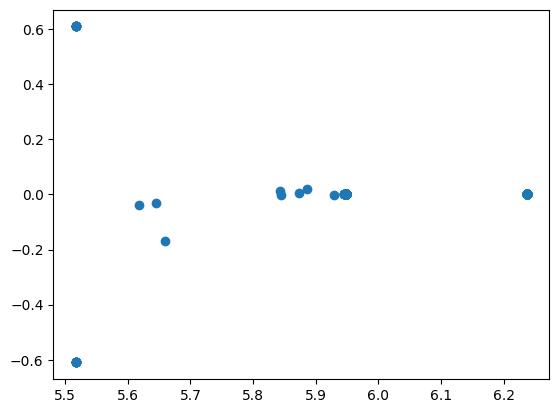

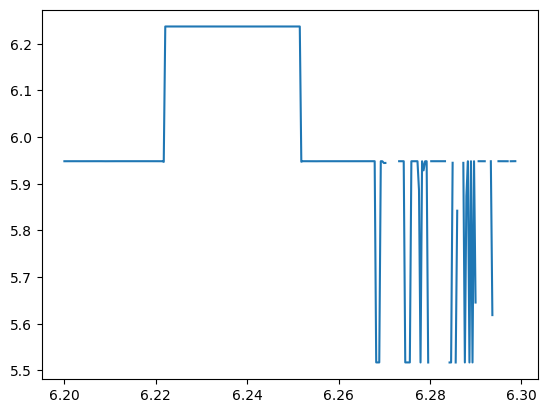

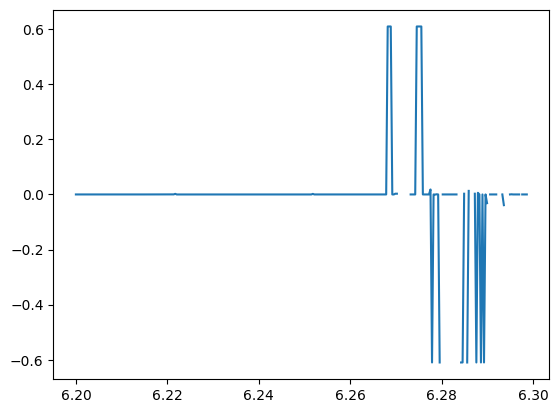

In [30]:
x, y, z = pos
plt.scatter(x, z)
plt.figure()
plt.plot(xStart, x)
plt.figure()
plt.plot(xStart, z)

x

The iota profile is returned in a shape matching the start point shape, and can be easily plotted.

In [31]:
iotas

array([0.96326829, 0.96335969, 0.96383524, 0.96456239, 0.96618223,
       0.96653242, 0.96668686, 0.96773338, 0.96825692, 0.96840767,
       0.96894276, 0.97089424, 0.97135471, 0.97165079, 0.97315589,
       0.97339479, 0.97386637, 0.97655515, 0.9766509 , 0.98925674,
       0.98829173, 0.9992276 , 0.995716  , 0.99905179, 1.00290291,
       1.00048943, 1.00014198, 1.00013398, 1.0009039 , 0.99908899,
       0.99906526, 1.00090936, 0.99909251, 0.99909219, 0.99908704,
       0.99907035, 1.00031577, 1.00087288, 1.00043938, 0.99949848,
       0.99913429, 0.99932934, 1.00021399, 1.00066333, 1.00078028,
       1.00066828, 1.00024202, 0.99950688, 0.99926218, 0.99925851,
       0.99949515, 0.99999571, 1.00067404, 1.00066997, 1.00061785,
       1.00061761, 1.00059745, 1.0006184 , 1.00046185, 1.00023192,
       1.00000371, 0.99972681, 0.99956477, 0.99949732, 0.99940436,
       0.99941789, 1.08867842, 1.08861497, 1.08868812, 1.08900347,
       1.09106337, 1.09123525, 1.09128231, 1.09129076, 1.09128

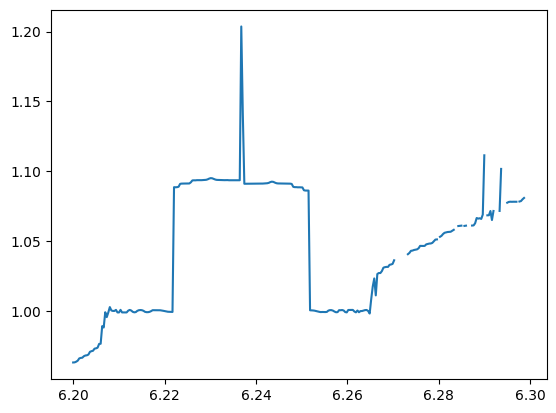

In [32]:
plt.plot(xStart, iotas)

Additionally, the field line tracer can also extract the Fourier decomposition of the magnetic surfaces from the field line. 

In [ ]:
modes = fsc.flt.calculateFourierModes(
    field, [xStart, yStart, zStart],
    30, # Turn count
    nMax = 15, mMax = 5, toroidalSymmetry = 5,
    unwrapEvery = 10, recordEvery = 1,
    targetError = 1e-4, distanceLimit = 1e5, maxStepSize = 0.01,
    stellaratorSymmetric = True, aliasThreshold = 0.05,
    islandM = 5
)

The modes are returned with a dict containing rotational transform and the Fourier expansion of the modes, as well as an encoding of the result as a FourierSurfaces object that can also be used in VMEC inputs.

In [7]:
modes.keys()

dict_keys(['surfaces', 'iota', 'theta', 'rCos', 'zSin', 'mPol', 'nTor'])

Of particular interest are two components: The first one is the 'iota' array, which returns the rotational transforms.

In [8]:
modes["iota"]

array([       nan,        nan,        nan, 1.0286169 , 1.01705426,
       0.99871879, 1.00277328, 0.97882054, 0.96794947, 0.95869316,
       0.94888016, 0.93946424, 0.93049668, 0.92216556, 0.91444518,
       0.90714442, 0.90054655, 0.89460341, 0.88946499, 0.88454062,
       0.88054075, 0.87691851, 0.87350063, 0.87047301, 0.86789686,
       0.86584818, 0.86382453, 0.86214333, 0.86064236, 0.85956153,
       0.85874602, 0.85782564, 0.85700342, 0.85620073, 0.85566841,
       0.85545212, 0.85520535, 0.85435101, 0.85301676, 0.85275   ,
       0.85364424, 0.85425248, 0.85534412, 0.85613699, 0.85627033,
       0.85656847, 0.85708361, 0.85780644, 0.85864923, 0.85948652,
       0.86039479, 0.86121336, 0.8624535 , 0.86383576, 0.86550188,
       0.86729133, 0.86948356, 0.8720122 , 0.87449011, 0.87725589,
       0.88052073, 0.88446288, 0.88808946, 0.89253401, 0.89775984,
       0.90282253, 0.90893061, 0.9149626 , 0.92202657, 0.92943698,
       0.93715673, 0.94632955, 0.95635302, 0.96889753, 1.00027

Secondarily relevant is the 'surfaces' element, which contains the magnetic surfaces. This is an instance of the class fusionsc.magnetics.SurfaceArray, which can be sliced, added, and multiplied similar to a regular NumPy array.

In [9]:
modes["theta"]

array([            nan,             nan,             nan,  8.81186241e-01,
        6.36629336e-01, -8.14869220e-02,  1.41502978e+00,  2.99240068e+00,
        3.04538176e+00,  3.08288192e+00,  3.06249137e+00,  3.05842520e+00,
        3.07234783e+00,  3.07145239e+00,  3.06979940e+00,  3.06023571e+00,
        3.05430525e+00,  3.04507752e+00,  3.06747052e+00,  3.05071405e+00,
        3.05881901e+00,  3.07880619e+00,  3.07450881e+00,  3.06490730e+00,
        3.05317773e+00,  3.06425097e+00,  3.05528457e+00,  3.05755887e+00,
        3.04995527e+00,  3.05640022e+00,  3.07159740e+00,  3.07305549e+00,
        3.07835494e+00,  3.06609995e+00,  3.05234856e+00,  3.05629783e+00,
        3.07646309e+00,  3.07540761e+00,  3.04712219e+00,  3.07812480e+00,
        1.52484993e-02,  6.06804760e-03,  1.31711937e-02,  1.43301712e-02,
       -1.13065090e-02, -6.62581754e-03,  5.86472329e-03,  1.37631291e-02,
        1.58500927e-02,  1.20587972e-02,  1.29929418e-02, -5.22753062e-03,
       -3.10750846e-03, -

To plot the modes, we need to multiply the Fourier coefficients with the appropriate angles.

In [12]:
surfaces = modes["surfaces"]

print(type(surfaces))

<class 'fusionsc.magnetics.SurfaceArray'>


(3, 40, 3, 100)


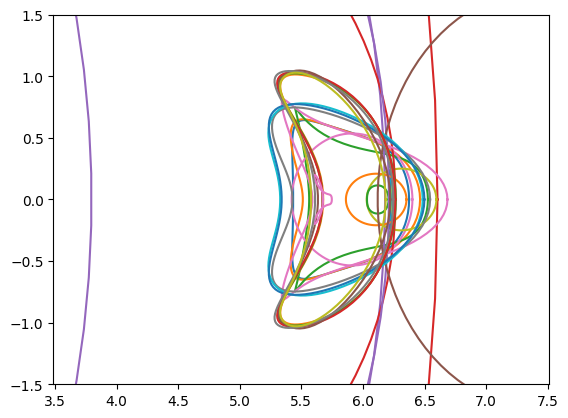

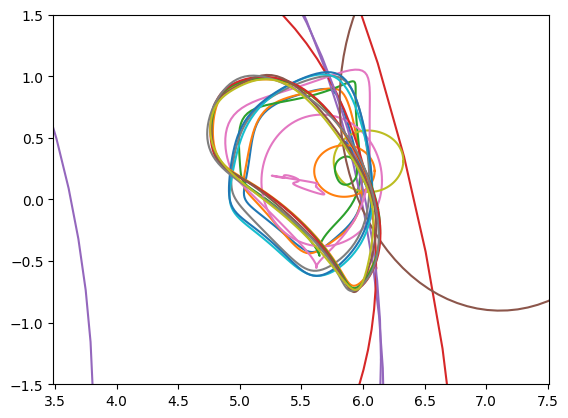

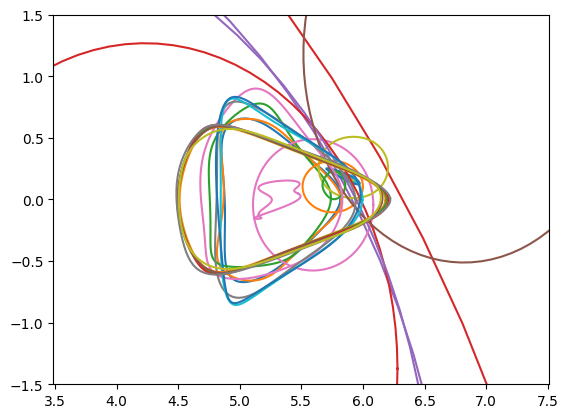

In [13]:
iSurf = 0
thetas = np.linspace(0, 2 * np.pi, 100)
phis = np.linspace(0, 2 * np.pi / 10, 3)

data = surfaces.evaluate(phis, thetas) # Surfaces -5, -4, -3 are rational and failed to reconstruct

print(data['points'].shape)

for iPhi in range(len(phis)):
    plt.figure()
    for iSurf in range(0, surfaces.shape[0]):
        #if abs(modes['iota'][iSurf] - 1) < 0.02:
        #    continue
            
        dp = 1
        x, y, z = data['points'][:,iSurf,iPhi,::dp]
        dx, dy, dz = data['thetaDerivatives'][:,iSurf,iPhi,::dp]
        
        r = np.sqrt(x**2 + y**2)
        
        dr = (dx * x + dy * y) / r
        
        
        plt.plot(r, z)
        #plt.quiver(r, z, dr, dz)
    plt.axis('equal')
    plt.xlim(4, 7)
    plt.ylim(-1.5, 1.5)
plt.show()

The obtained surfaces can also be used to calculate a mode decomposition of the magnetic field

In [13]:
surfaces[2].asGeometry(nPhi = 360, nTheta = 360).asPyvista().plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

C:\Users\Knieps\Documents\repos\fsc\src\python\fusionsc\_api_markers.py:15: UserWarning: The function fusionsc.magnetics.MagneticConfig.calculateRadialModes is part of the unstable API. It might change or get removed in the near future. While unlikely, it might also not be compatible across client/server versions.
  warnings.warn(f"The function {f.__module__}.{f.__qualname__} is part of the unstable API. It might change or get removed in the near future. While unlikely, it might also not be compatible across client/server versions.")
C:\Users\Knieps\Documents\repos\fsc\src\python\fusionsc\magnetics.py:402: UserWarning: calculateRadialModes can only use the FFT fast path if nPhi == 2 * nMax + 1 and nTheta == 2 * mMax + 1. Other values are not recommended
  warnings.warn("calculateRadialModes can only use the FFT fast path if nPhi == 2 * nMax + 1 and nTheta == 2 * mMax + 1. Other values are not recommended")


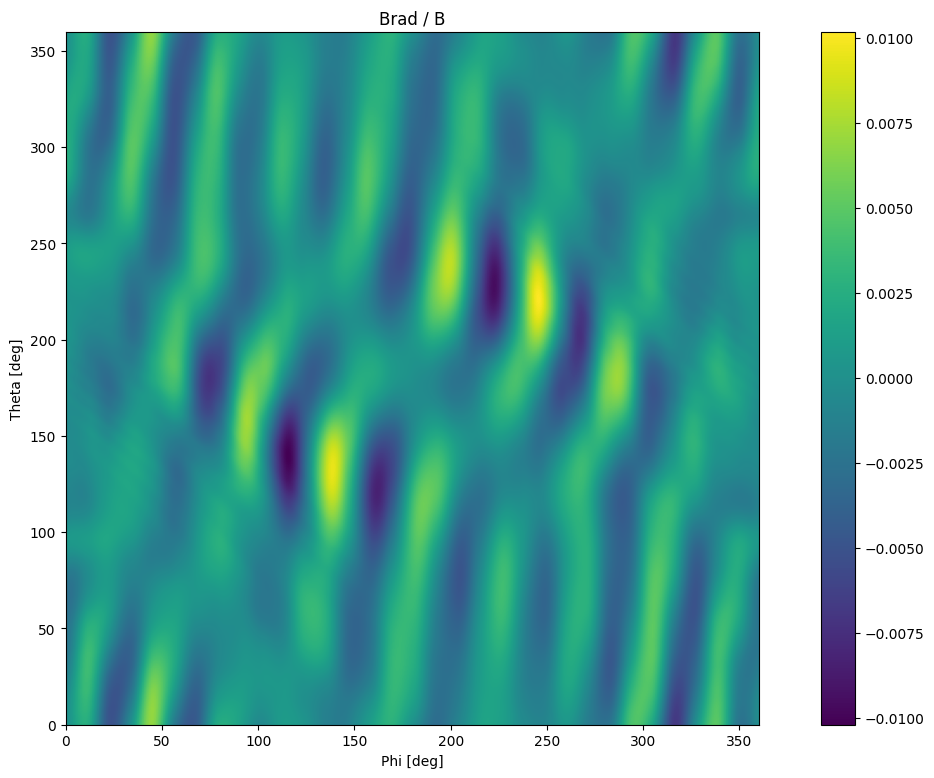

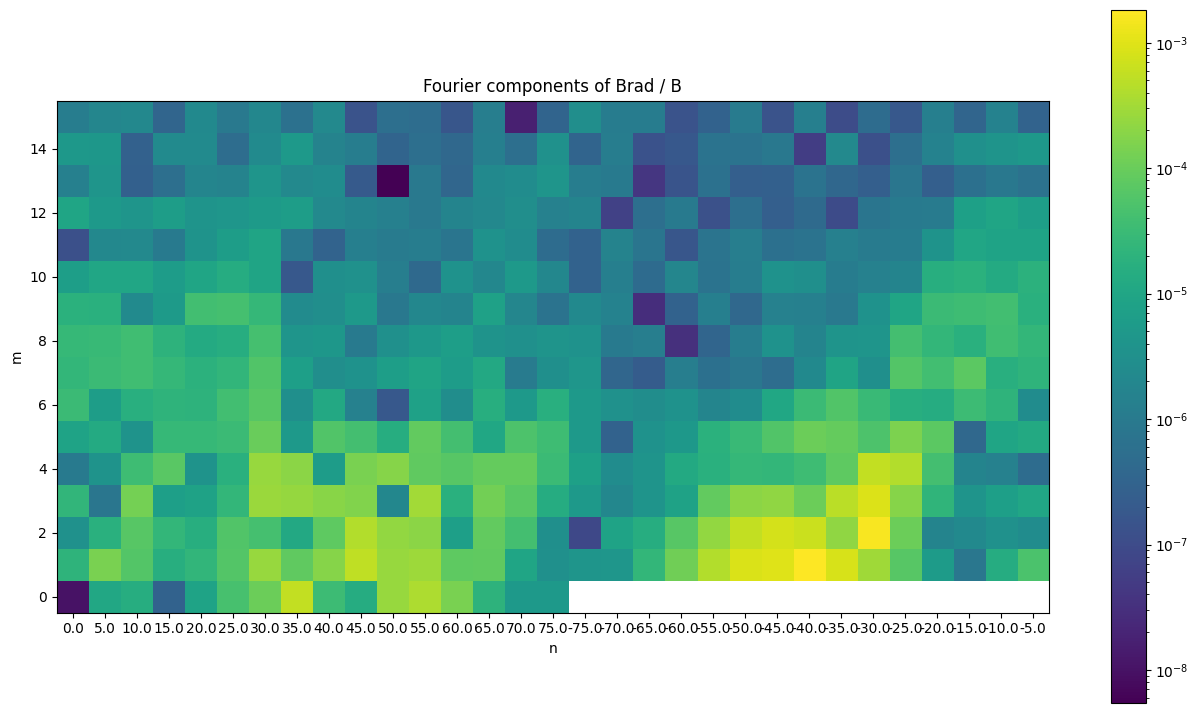

(400, 400)
n = 0, m = 0, val = 1.03e-08
n = 5, m = 0, val = 1.11e-05
n = 10, m = 0, val = 1.54e-05
n = 0, m = 1, val = 2.16e-05
n = 5, m = 1, val = 1.41e-04
n = 10, m = 1, val = 5.95e-05
n = 0, m = 2, val = 3.35e-06
n = 5, m = 2, val = 1.77e-05
n = 10, m = 2, val = 6.80e-05
n = 0, m = 3, val = 2.31e-05
n = 5, m = 3, val = 8.20e-07
n = 10, m = 3, val = 1.26e-04
n = 0, m = 4, val = 1.01e-06
n = 5, m = 4, val = 3.73e-06
n = 10, m = 4, val = 3.56e-05
n = 0, m = 5, val = 8.56e-06
n = 5, m = 5, val = 1.32e-05
n = 10, m = 5, val = 3.83e-06


In [14]:
surf = surfaces[6]
#np.asarray(surf.data.rCos)[0,0] += 0.03

fieldModes = field.calculateRadialModes(surf, field, nSym = 5, mMax = 15, nMax = 15, nTheta = 400, nPhi = 400)
cc = fieldModes["cosCoeffs"]
sc = fieldModes["sinCoeffs"]

m = fieldModes["mPol"]
n = fieldModes["nTor"]

phi = fieldModes["phi"]
theta = fieldModes["theta"]

tot = np.sqrt(cc**2 + sc**2)

plt.figure(figsize=(16,9))
plt.imshow(fieldModes["radialValues"].T, origin='lower', extent = [0, 360, 0, 360])
plt.colorbar()
plt.title("Brad / B")
plt.xlabel('Phi [deg]')
plt.ylabel('Theta [deg]')

plt.figure(figsize=(16,9))
plt.imshow(tot.T, origin = "lower", norm = "log")
#plt.xlabel(f"n[0, {n[1]:.0f} ... {max(n):.0f}, {min(n):.0f}, ..., {n[-1]:.0f}]")
plt.xlabel("n")
plt.ylabel("m")
plt.xticks(range(len(n)), n)
plt.title("Fourier components of Brad / B")
plt.colorbar()
plt.show()

print(fieldModes["radialValues"].shape)
for i_m, mVal in enumerate(m):
    for i_n, nVal in enumerate(n):
        if mVal > 5: continue
        if nVal < 0: continue
        if nVal > 10: continue
        print(f"n = {nVal:.0f}, m = {mVal:.0f}, val = {tot[i_n][i_m]:.2e}")


The calculated surfaces can also be converted into geometries to plot.

C:\Users\Alexander\AppData\Roaming\Python\Python310\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


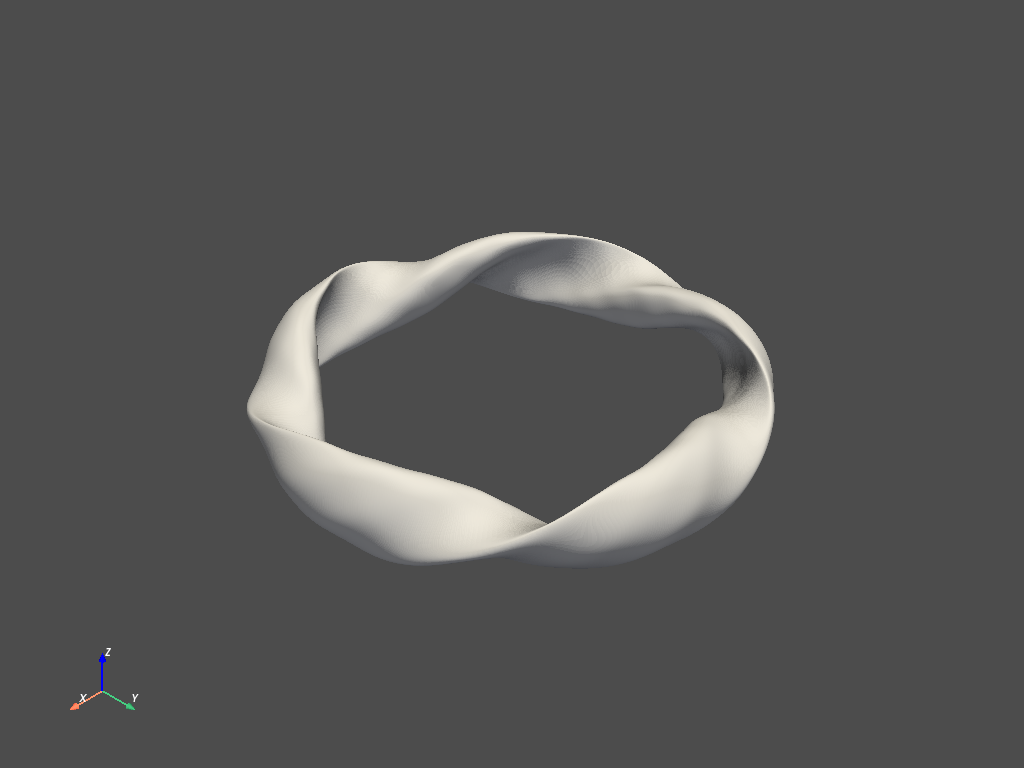

In [20]:
asPv = surfaces[0].asGeometry(nPhi = 360, nTheta = 360).asPyvista()
asPv.plot()

In [62]:
surfs = []

for phi in np.linspace(0, 2 * np.pi, 5, endpoint = False):
    rStart = -np.linspace(4.5, 4.65, 15)
    
    xStart = np.cos(phi) * rStart
    yStart = np.sin(phi) * rStart
    zStart = 0 * xStart

    print(xStart, yStart)
    
    modes2 = fsc.flt.calculateFourierModes(
        field, [xStart, yStart, zStart],
        30, # Turn count
        nMax = 5, mMax = 7, toroidalSymmetry = 5,
        unwrapEvery = 10, recordEvery = 1,
        targetError = 1e-3, distanceLimit = 1e5, maxStepSize = 0.01,
        stellaratorSymmetric = False, aliasThreshold = 0.05,
        islandM = 5
    )

    surfs.append(modes2["surfaces"])

[-4.5        -4.51071429 -4.52142857 -4.53214286 -4.54285714 -4.55357143
 -4.56428571 -4.575      -4.58571429 -4.59642857 -4.60714286 -4.61785714
 -4.62857143 -4.63928571 -4.65      ] [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
[-1.39057647 -1.39388737 -1.39719827 -1.40050916 -1.40382006 -1.40713096
 -1.41044185 -1.41375275 -1.41706365 -1.42037454 -1.42368544 -1.42699633
 -1.43030723 -1.43361813 -1.43692902] [-4.27975432 -4.28994421 -4.30013411 -4.310324   -4.32051389 -4.33070378
 -4.34089367 -4.35108356 -4.36127345 -4.37146334 -4.38165324 -4.39184313
 -4.40203302 -4.41222291 -4.4224128 ]
[3.64057647 3.64924451 3.65791255 3.66658059 3.67524863 3.68391667
 3.69258471 3.70125275 3.70992079 3.71858883 3.72725687 3.73592491
 3.74459295 3.75326098 3.76192902] [-2.64503364 -2.65133133 -2.65762903 -2.66392673 -2.67022443 -2.67652213
 -2.68281983 -2.68911753 -2.69541523 -2.70171293 -2.70801063 -2.71430833
 -2.72060602 -2.72690372 -2.73320142]
[3.64057647 3.64924451 3.65791255

In [69]:
geo = sum([s[14].asGeometry(nPhi = 360, nTheta = 360) for s in surfs])
geo = geo.planarClip(normal = [1,0,0])
geo.asPyvista().plot(notebook = False)

In [23]:
surfaces2.asGeometry(nPhi = 360, nTheta = 360).asPyvista().plot(notebook = False)